/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Device set to use cpu
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eo

Augmented dataset created with synthetic fake & real reviews!


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/5
1016/1016 ━━━━━━━━━━━━━━━━━━━━ 247s 235ms/step - accuracy: 0.8338 - loss: 0.3597 - val_accuracy: 0.9284 - val_loss: 0.1821
Epoch 2/5
1016/1016 ━━━━━━━━━━━━━━━━━━━━ 267s 241ms/step - accuracy: 0.9495 - loss: 0.1323 - val_accuracy: 0.9353 - val_loss: 0.1804
Epoch 3/5
1016/1016 ━━━━━━━━━━━━━━━━━━━━ 262s 241ms/step - accuracy: 0.9680 - loss: 0.0903 - val_accuracy: 0.9328 - val_loss: 0.2094
Epoch 4/5
1016/1016 ━━━━━━━━━━━━━━━━━━━━ 260s 239ms/step - accuracy: 0.9776 - loss: 0.0667 - val_accuracy: 0.9326 - val_loss: 0.2332
Epoch 5/5
1016/1016 ━━━━━━━━━━━━━━━━━━━━ 262s 239ms/step - accuracy: 0.9834 - loss: 0.0496 - val_accuracy: 0.9344 - val_loss: 0.2566
254/254 ━━━━━━━━━━━━━━━━━━━━ 14s 54ms/step
Accuracy: 0.9344161437184693
Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.94      0.93      4064
           1       0.94      0.93      0.93      4063

    accuracy                           0.93      8127
   macro avg       0.

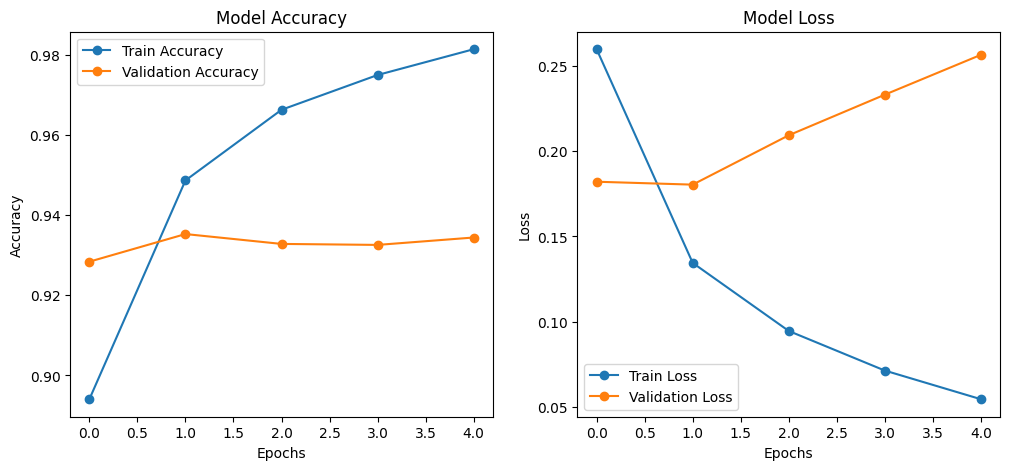

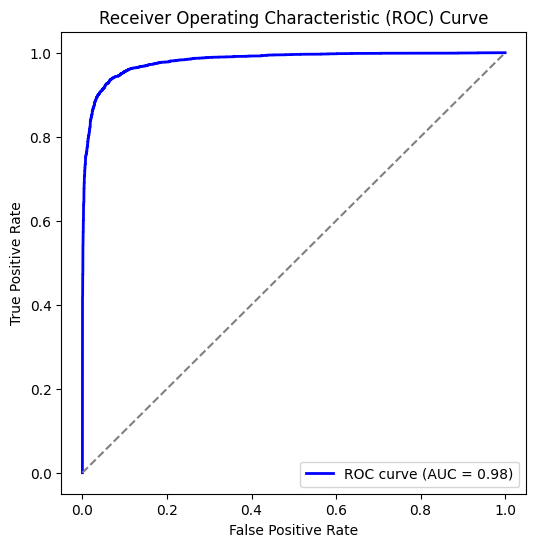

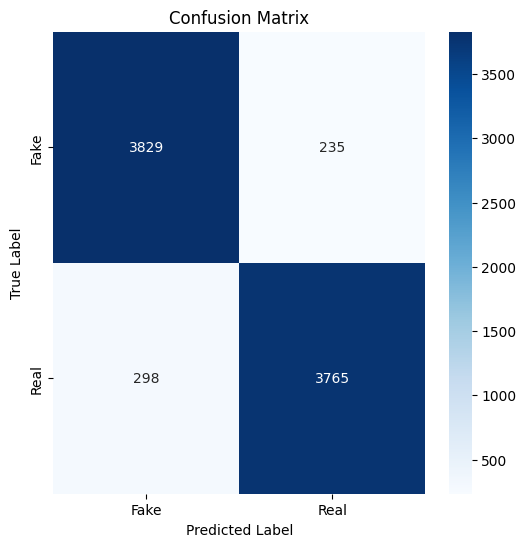

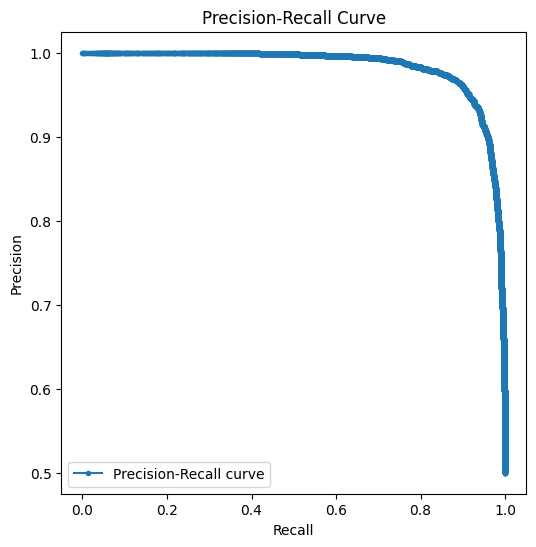

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Bidirectional, Dense, Dropout
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, roc_curve, auc, confusion_matrix, precision_recall_curve
from transformers import pipeline

# Load dataset
df = pd.read_csv('/content/Preprocessed Fake Reviews Detection Dataset.csv')
df = df.dropna(subset=['text_'])  # Remove missing values

# Data Augmentation using GPT-2
generator = pipeline("text-generation", model="gpt2")

def generate_fake_review():
    prompt = "This product is absolutely amazing because"
    generated_text = generator(prompt, max_length=50, num_return_sequences=1)
    return generated_text[0]['generated_text'].strip()

def generate_real_review():
    prompt = "As a satisfied customer, I think this product"
    generated_text = generator(prompt, max_length=50, num_return_sequences=1)
    return generated_text[0]['generated_text'].strip()

# Generate synthetic reviews
fake_reviews = [generate_fake_review() for _ in range(100)]
real_reviews = [generate_real_review() for _ in range(100)]

# Create DataFrames for synthetic reviews
fake_df = pd.DataFrame({'text_': fake_reviews, 'label': 0})  # Fake = 0
real_df = pd.DataFrame({'text_': real_reviews, 'label': 1})  # Real = 1

# Merge with original dataset
df_augmented = pd.concat([df, fake_df, real_df], ignore_index=True)
df_augmented.to_csv('/content/Augmented_Fake_Reviews.csv', index=False)

print("Augmented dataset created with synthetic fake & real reviews!")

# Features and labels
X = df_augmented['text_'].values
y = df_augmented['label'].values

# Tokenization
max_words = 10000
max_len = 100
tokenizer = Tokenizer(num_words=max_words, oov_token="<OOV>")
tokenizer.fit_on_texts(X)
X_sequences = tokenizer.texts_to_sequences(X)
X_padded = pad_sequences(X_sequences, maxlen=max_len, padding='post', truncating='post')

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X_padded, y, test_size=0.2, random_state=42, stratify=y)

# Define LSTM model
model = Sequential([
    Embedding(input_dim=max_words, output_dim=128, input_length=max_len),
    Bidirectional(LSTM(64, return_sequences=True)),
    Dropout(0.5),
    Bidirectional(LSTM(32)),
    Dense(32, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

# Compile model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train model and store history
history = model.fit(X_train, y_train, epochs=5, batch_size=32, validation_data=(X_test, y_test))

# Evaluate model
y_pred_probs = model.predict(X_test)
y_pred = (y_pred_probs > 0.5).astype(int)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

# ------------------------------
# 1. Accuracy & Loss Graphs
# ------------------------------
plt.figure(figsize=(12, 5))

# Accuracy Plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy', marker='o')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')
plt.legend()

# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss', marker='o')
plt.plot(history.history['val_loss'], label='Validation Loss', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss')
plt.legend()

plt.show()

# ------------------------------
# 2. ROC Curve
# ------------------------------
fpr, tpr, _ = roc_curve(y_test, y_pred_probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# ------------------------------
# 3. Confusion Matrix
# ------------------------------
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Fake', 'Real'], yticklabels=['Fake', 'Real'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# ------------------------------
# 4. Precision-Recall Curve
# ------------------------------
precision, recall, _ = precision_recall_curve(y_test, y_pred_probs)

plt.figure(figsize=(6, 6))
plt.plot(recall, precision, marker='.', label='Precision-Recall curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()
